In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('effect_data.csv')

In [2]:
data.head()

,Unnamed: 0,species,chemical,conc (mol/L)
0,0,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/10025919,3.051629
1,1,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/10028156,5.681105
2,2,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100414,3.398977
3,3,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/100425,3.512146
4,4,https://cfpub.epa.gov/ecotox/taxon/1,https://cfpub.epa.gov/ecotox/cas/10043013,3.127255


<AxesSubplot:>

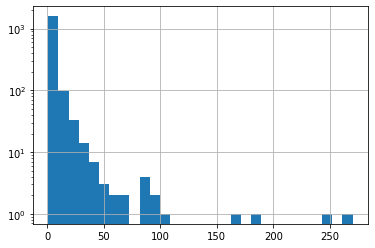

In [3]:
data.groupby('species').count().chemical.hist(bins=30,log=True)

<AxesSubplot:>

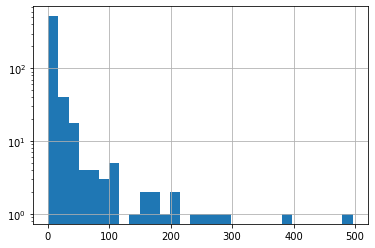

In [4]:
data.groupby('chemical').count().species.hist(bins=30,log=True)

(4.13464533786474, 1.691965380643943)

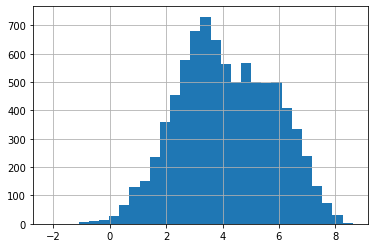

In [5]:
data['conc (mol/L)'].hist(bins=30)
data['conc (mol/L)'].mean(),data['conc (mol/L)'].std()

In [6]:
mapping_species = {k:i for i,k in enumerate(data.species.unique())}
mapping_chemical = {k:i for i,k in enumerate(data.chemical.unique())}

In [7]:
M = np.zeros((len(mapping_species),len(mapping_chemical)))

In [8]:
for i,j in zip(data.species,data.chemical):
    i = mapping_species[i]
    j = mapping_chemical[j]
    M[i,j] = 1

In [9]:
np.unique(M,return_counts=True)

(array([0., 1.]), array([1055548,    8452]))

In [10]:
#SLOW
from itertools import product
import tqdm.notebook as tq

def split_submatrix(x,submat_shape):
    h,w = submat_shape
    
    m = x.ravel()
    
    for idx in product(*[np.arange(x.shape[0]) for i in range(h)],
                       *[np.arange(x.shape[1]) for i in range(w)]):
        
        idx = np.unique(idx,axis=0)
        yield m[idx]
        
t_max = 7
for k,l in tq.tqdm(product(range(2,t_max),range(2,t_max)),
                   total = (t_max-2)**2):
    for m in split_submatrix(M,(k,l)):
        if m.sum() >= k*l*0.8:
            print(k,l,k*l)
            break

2 2 4



KeyboardInterrupt: 

In [44]:
import networkx as nx

G = nx.DiGraph()

for s,c in zip(data.species,data.chemical):
    G.add_edge(s,c)
    G.add_edge(c,s)
    
edges_to_remove = []
for edge in G.edges():
    if (edge[1],edge[0]) in G.edges() and (edge[1],edge[0]) not in edges_to_remove:
        edges_to_remove.append(edge)
        
for edge in edges_to_remove:
    G.remove_edge(*edge)

In [45]:
G.number_of_nodes(),G.number_of_edges()

(2358, 8452)

In [48]:
nx.algorithms.dag.dag_longest_path(G)

['https://cfpub.epa.gov/ecotox/cas/12027677',
 'https://cfpub.epa.gov/ecotox/taxon/532',
 'https://cfpub.epa.gov/ecotox/cas/7788989',
 'https://cfpub.epa.gov/ecotox/taxon/5',
 'https://cfpub.epa.gov/ecotox/cas/10026116',
 'https://cfpub.epa.gov/ecotox/taxon/4',
 'https://cfpub.epa.gov/ecotox/cas/1310538',
 'https://cfpub.epa.gov/ecotox/taxon/25',
 'https://cfpub.epa.gov/ecotox/cas/106956',
 'https://cfpub.epa.gov/ecotox/taxon/206',
 'https://cfpub.epa.gov/ecotox/cas/107926',
 'https://cfpub.epa.gov/ecotox/taxon/2',
 'https://cfpub.epa.gov/ecotox/cas/120127',
 'https://cfpub.epa.gov/ecotox/taxon/142',
 'https://cfpub.epa.gov/ecotox/cas/479458',
 'https://cfpub.epa.gov/ecotox/taxon/1196',
 'https://cfpub.epa.gov/ecotox/cas/88891',
 'https://cfpub.epa.gov/ecotox/taxon/109',
 'https://cfpub.epa.gov/ecotox/cas/7773015',
 'https://cfpub.epa.gov/ecotox/taxon/10300',
 'https://cfpub.epa.gov/ecotox/cas/137268',
 'https://cfpub.epa.gov/ecotox/taxon/102',
 'https://cfpub.epa.gov/ecotox/cas/529186